In [1]:
from function import *
import numpy as np
import networkx as nx
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

#### LOAD THE DATA

In [3]:
# Using Random Data

N = 100000                # Number of data
d = 2                     # Number of features
precision = 2             # Control precision bit of the output
dim = d * (2 * precision) # Size of the QUBO matrix
degree = 2                # Degree of the polynomial regression

# Generate Random Data
X = np.random.rand(N, d)
Y = np.random.rand(N)

# Train-Test data splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# If you want to perform polynomial regression
X_train, d, dim = polynomialForm(X_train, d, dim, precision, degree)
X_test, _, _ = polynomialForm(X_test, d, dim, precision, degree) 

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(80000, 6)
(20000, 6)
(80000,)
(20000,)


#### COMPUTING SOME IMPORTANT VARIABLES
Initiating variables that required to creating QUBO Matrix

In [4]:
XtX = np.matmul(X_train.T, X_train) # Covariance matrix
XtY = np.matmul(X_train.T, Y_train) # Relation between Features and Y

print(XtX)
print(XtY)

[[80000.         40227.81171168 40070.79882127 26897.242423
  20126.78297952 26745.17900141]
 [40227.81171168 26897.242423   20126.78297952 20210.80526164
  13443.44545123 13428.02811463]
 [40070.79882127 20126.78297952 26745.17900141 13443.44545123
  13428.02811463 20066.25359548]
 [26897.242423   20210.80526164 13443.44545123 16189.86366926
  10095.02117523  8963.40306557]
 [20126.78297952 13443.44545123 13428.02811463 10095.02117523
   8963.40306557 10072.29116102]
 [26745.17900141 13428.02811463 20066.25359548  8963.40306557
  10072.29116102 16051.19292095]]
[40016.70392666 20115.64982732 20043.18687923 13443.98734649
 10056.59535841 13378.6673854 ]


#### FIXSTAR AMPLIFY SIMULATED ANNEALER

In [5]:
model = generateQuboMatrix_fixstar(XtX, XtY, dim, precision, d)
distributions_fixstar, weights_fixstar = solve_fixstar(model, dim, precision, d)

In [6]:
Y_train_pred_fixstar = np.dot(X_train, weights_fixstar)
Y_test_pred_fixstar = np.dot(X_test, weights_fixstar)

# Evaluate on training data
train_mse_fixstar = mean_squared_error(Y_train, Y_train_pred_fixstar)
train_mae_fixstar = mean_absolute_error(Y_train, Y_train_pred_fixstar)
train_r2_fixstar = r2_score(Y_train, Y_train_pred_fixstar) 

# Evaluate on test data
test_mse_fixstar = mean_squared_error(Y_test, Y_test_pred_fixstar)
test_mae_fixstar = mean_absolute_error(Y_test, Y_test_pred_fixstar)
test_r2_fixstar = r2_score(Y_test, Y_test_pred_fixstar)

# Print the metrics
print("Fixstar Training Evaluation:")
print(f"MSE: {train_mse_fixstar:.5f}, MAE: {train_mae_fixstar:.5f}, R²: {train_r2_fixstar:.5f}")    

print("\nFixstar Testing Evaluation:")
print(f"MSE: {test_mse_fixstar:.5f}, MAE: {test_mae_fixstar:.5f}, R²: {test_r2_fixstar:.5f}")  

Fixstar Training Evaluation:
MSE: 0.08312, MAE: 0.24970, R²: -0.00000

Fixstar Testing Evaluation:
MSE: 0.08319, MAE: 0.24927, R²: -0.00000


#### NEAL SIMULATED ANNEALER

In [7]:
Q = generateQuboMatrix_neal(XtX, XtY, precision, d)
sampleset = sampling(Q)
distributions_neal, weights_neal = solve_neal(sampleset, dim, precision, d)

In [8]:
Y_train_pred_neal = np.dot(X_train, weights_neal)
Y_test_pred_neal = np.dot(X_test, weights_neal)

# Evaluate on training data
train_mse_neal = mean_squared_error(Y_train, Y_train_pred_neal)
train_mae_neal = mean_absolute_error(Y_train, Y_train_pred_neal)
train_r2_neal = r2_score(Y_train, Y_train_pred_neal)

# Evaluate on test data
test_mse_neal = mean_squared_error(Y_test, Y_test_pred_neal)
test_mae_neal = mean_absolute_error(Y_test, Y_test_pred_neal)
test_r2_neal = r2_score(Y_test, Y_test_pred_neal)

# Print the metrics
print("Neal Training Evaluation:")
print(f"MSE: {train_mse_neal:.5f}, MAE: {train_mae_neal:.5f}, R²: {train_r2_neal:.5f}")

print("\nNeal Testing Evaluation:")
print(f"MSE: {test_mse_neal:.5f}, MAE: {test_mae_neal:.5f}, R²: {test_r2_neal:.5f}")

Neal Training Evaluation:
MSE: 0.14023, MAE: 0.30676, R²: -0.68703

Neal Testing Evaluation:
MSE: 0.14037, MAE: 0.30681, R²: -0.68747


#### SCIKIT LEARN (TRADISIONAL WAY)

In [9]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

start_time = time.time() 

clf = LinearRegression()
clf.fit(X_train, Y_train)
print("Coefficients:", clf.coef_)

Y_train_pred_sklearn = clf.predict(X_train)
Y_test_pred_sklearn = clf.predict(X_test)

# Evaluate on training data
train_mse_sklearn = mean_squared_error(Y_train, Y_train_pred_sklearn)
train_mae_sklearn = mean_absolute_error(Y_train, Y_train_pred_sklearn)
train_r2_sklearn = r2_score(Y_train, Y_train_pred_sklearn) 

# Evaluate on test data
test_mse_sklearn = mean_squared_error(Y_test, Y_test_pred_sklearn)
test_mae_sklearn = mean_absolute_error(Y_test, Y_test_pred_sklearn)
test_r2_sklearn = r2_score(Y_test, Y_test_pred_sklearn)

end_time = time.time()  
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.5f} seconds\n")

# Print the metrics
print("Fixstar Training Evaluation:")
print(f"MSE: {train_mse_sklearn:.5f}, MAE: {train_mae_sklearn:.5f}, R²: {train_r2_sklearn:.5f}")    

print("\nFixstar Testing Evaluation:")
print(f"MSE: {test_mse_sklearn:.5f}, MAE: {test_mae_sklearn:.5f}, R²: {test_r2_sklearn:.5f}")  

Coefficients: [ 0.          0.01371347  0.00426843 -0.00804445 -0.01329644  0.00232553]
Execution time: 0.03505 seconds

Fixstar Training Evaluation:
MSE: 0.08312, MAE: 0.24970, R²: 0.00002

Fixstar Testing Evaluation:
MSE: 0.08319, MAE: 0.24928, R²: -0.00005


#### VISUALIZATION OF GRAPH

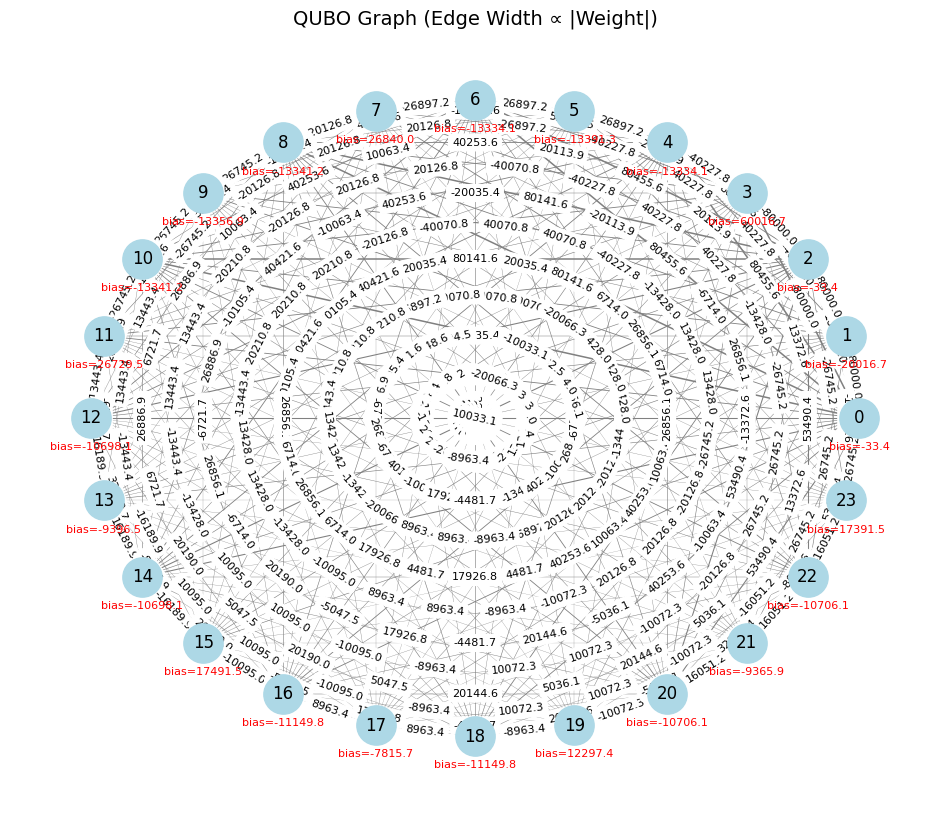

In [11]:
# Initialize the graph and add all nodes first
G = nx.Graph()
nodes = set()
for (i, j) in Q.keys():
    nodes.add(i)
    nodes.add(j)
G.add_nodes_from(nodes)

# Now add edges and node attributes
for (i, j), weight in Q.items():
    if weight != 0 and i <= j:  # Avoid duplicates and zero-weights
        if i == j:
            G.nodes[i]['bias'] = weight  # Now safe because node exists
        else:
            G.add_edge(i, j, weight=weight)

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.circular_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=12)

# Scale edge widths by absolute weight
max_weight = max(abs(d['weight']) for _, _, d in G.edges(data=True))
edge_widths = [0.1 + 2 * abs(G[u][v]['weight']) / max_weight for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

# Add edge labels (rounded)
edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Add node biases
for node, (x, y) in pos.items():
    bias = G.nodes[node].get('bias', 0)
    plt.text(x, y-0.1, f"bias={bias:.1f}", ha='center', fontsize=8, color='red')

plt.title("QUBO Graph (Edge Width ∝ |Weight|)", fontsize=14)
plt.axis('off')
plt.show()

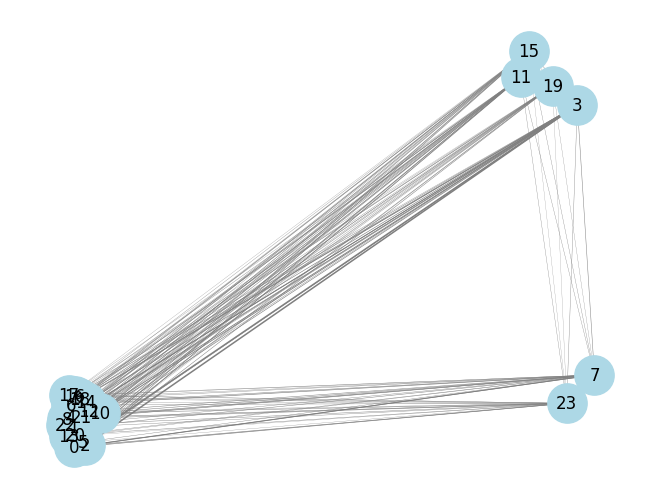

In [12]:
pos = nx.spring_layout(G, k=0.5, weight='weight', iterations=100)
nx.draw(G, pos, with_labels=True, 
       node_color='lightblue', node_size=800,
       width=[0.1 + 2*abs(G[u][v]['weight'])/max_weight for u,v in G.edges()],
       edge_color='gray')

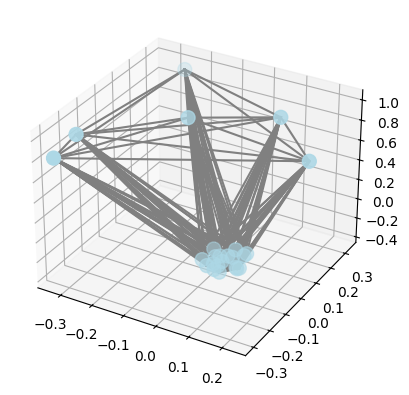

In [13]:
from mpl_toolkits.mplot3d import Axes3D

pos = nx.spring_layout(G, dim=3, weight='weight')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for u, v in G.edges():
    ax.plot([pos[u][0], pos[v][0]], 
            [pos[u][1], pos[v][1]], 
            [pos[u][2], pos[v][2]], 
            'gray')
ax.scatter(*np.array(list(pos.values())).T, s=100, c='lightblue')
plt.show()

#### FINAL EVALUATION

In [10]:
data = {
    "Model": ["Neal", "Neal", "Fixstar", "Fixstar", "Sklearn", "Sklearn"],
    "Dataset": ["Train", "Test", "Train", "Test", "Train", "Test"],
    "MSE": [
        train_mse_neal, test_mse_neal,
        train_mse_fixstar, test_mse_fixstar,
        train_mse_sklearn, test_mse_sklearn
    ],
    "MAE": [
        train_mae_neal, test_mae_neal,
        train_mae_fixstar, test_mae_fixstar,
        train_mae_sklearn, test_mae_sklearn
    ],
    "R2 Score": [
        train_r2_neal, test_r2_neal,
        train_r2_fixstar, test_r2_fixstar,
        train_r2_sklearn, test_r2_sklearn
    ]
}

df_eval = pd.DataFrame(data)
df_eval

,Model,Dataset,MSE,MAE,R2 Score
0,Neal,Train,0.140232,0.306762,-6.870338e-01
1,Neal,Test,0.140375,0.306813,-6.874744e-01
2,Fixstar,Train,0.083123,0.249702,-5.244871e-07
3,Fixstar,Test,0.083187,0.249270,-4.378867e-06
4,Sklearn,Train,0.083122,0.249697,2.046688e-05
5,Sklearn,Test,0.083190,0.249276,-4.992980e-05
